Part IV Project - H-DenseUNet CNN Implementation for Automated Segmentation of MRI Scans

Next Steps:

1) Vectorise and allow preprocessing steps to apply to entire individual patients

In [2]:
#Libraries
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import numpy as np
import os
import cv2
import time
from random import randint
import SimpleITK as sitk

#CNN Libraries
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
from keras.layers.core import Dropout
import tensorflow as tf
# from tensorflow.keras.models import Model

#Visualisation Libraries
import plotly.graph_objects as go
import pydicom
import matplotlib.pyplot as plt

In [2]:
# %pip install opencv-python
# %pip install keras
# %pip install tensorflow==2.6
# %pip install --upgrade tensorflow
# %pip install protobuf==3.20.0
# %pip uninstall tensorflow
# %pip install tensorflow
# %pip install protobuf
# %pip install SimpleITK
# %pip install tensorflow

Example 

Height and Width of Single MRI Scan:  (512, 512)


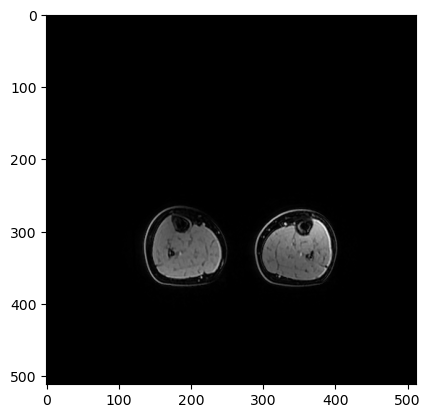

In [3]:
# Understanding the data format

# Read in Diacom file
example_mri_scan_file = pydicom.dcmread("D:/MRI - Tairawhiti/AutoBindWATER_450/IM-0046-0760.dcm")

# Assessing metadata within Diacom file
example_mri_scan = example_mri_scan_file.pixel_array

print('Height and Width of Single MRI Scan: ', example_mri_scan.shape)

plt.imshow(example_mri_scan, cmap='gray')
plt.show()

Helper Functions

In [4]:
def flatten_3d_to_2d(array_3d):
    # Get the dimensions of the 3D array
    depth, height, width = array_3d.shape
    
    # Reshape the 3D array to a 2D array
    array_2d = np.reshape(array_3d, (depth, height * width))
    
    return array_2d

def flatten_2d_array(arr):
    flattened = []
    for row in arr:
        flattened.extend(row)
    return flattened

Read In MRI Scan Data Procedure

In [5]:
# Read in entire scan of single patient
# folders = [f for f in os.listdir('MRI Scans - Tairawhiti') if os.path.isdir(os.path.join('MRI Scans - Tairawhiti', f))]
def ListFolders(directory):
    folder_names = []
    for root, dirs, files in os.walk(directory):
        for folder in dirs:
            folder_names.append(folder)
    return folder_names

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.endswith('.dcm'):
            try:
                dicom_file = pydicom.dcmread(filepath)
                dicom_files.append(dicom_file)
            except pydicom.errors.InvalidDicomError:
                print(f"Skipping file: {filename}. It is not a valid DICOM file.")
    return dicom_files


scans_path = 'D:/MRI - Tairawhiti'
folders = ListFolders(scans_path)
scan_pixel_data = []

for paitent in folders:
    single_scan_pixel_data = []
    single_paitent_scans_path =  scans_path + '/{}'.format(paitent)
    dicom_files = read_dicom_files(single_paitent_scans_path)
    for i in range (len(dicom_files)):
        single_scan_pixel_data.append(dicom_files[i].pixel_array)
    scan_pixel_data.append(single_scan_pixel_data)

training_scans = flatten_2d_array(scan_pixel_data)
training_scans = np.array(training_scans)

Exploratory Data Analysis

In [6]:
#plotly full body scan
def plotly_visualize_mri_scans(scans):
    # Create a figure object
    fig = go.Figure()

    # Iterate over the scans
    for i, scan in enumerate(scans):
        # Create a 3D surface plot for each scan
        surface = go.Surface(z=scan, colorscale='gray', showscale=False)
        fig.add_trace(surface)

    # Set layout properties
    fig.update_layout(
        scene=dict(
            aspectratio=dict(x=1, y=1, z=0.4),
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
        ),
        showlegend=False
    )

    # Create animation frames
    frames = [dict(data=[go.Surface(z=scan)]) for scan in scans]
    fig.frames = frames

    # Set animation properties
    animation = dict(
        frame=dict(duration=100),
        fromcurrent=True,
        transition=dict(duration=500, easing='quadratic-in-out'),
        mode='immediate'
    )

    # Add animation controls
    fig.update_layout(updatemenus=[dict(type='buttons', showactive=False,
                                        buttons=[dict(label='Play',
                                                      method='animate',
                                                      args=[None, animation])])])

    # Show the figure
    fig.show()

Visulisations

In [7]:
# Create matplotlib grayscale plot within python
def IndividualScanVisualisationGrayScalePlot(scan):
    plt.imshow(scan, cmap='gray')
    plt.show()

# Creates scan visualisation as pop up in new window
def IndividualScanVisualisation(scan):
    plt.imshow(scan, cmap='gray')
    plt.show()

Preprocessing Phase

In [8]:
def PreprocessingMRI(mri_scan_data, Normalization, Resizing, Cropping, Filtering):

    # Normalize image intensity (Image Normalization)
    if (Normalization == True):
        start_time = time.time()
        img_norm = mri_scan_data.astype(np.float32) / 255.0
        print("Normalization time: %s seconds" % (time.time() - start_time))

    # Resize image slices to 256x256 from 512x512 (Image Resizing)
    if (Resizing == True):
        start_time = time.time()
        resized_slices = []
        for i in range(img_norm.shape[0]):
            resized_slices.append(cv2.resize(img_norm[i], (256, 256)))
        img_resized = np.stack(resized_slices)
        print("Resizing time: %s seconds" % (time.time() - start_time))

    # Crop image slices to remove irrelevant information (Image cropping)
    if (Cropping == True):
        start_time = time.time()
        img_cropped = img_resized[:, 50:200, 50:200]
        print("Cropping time: %s seconds" % (time.time() - start_time))

    # Apply median filtering to each image slice to remove noise (Image Filtering - Noise Reduction)
    if (Filtering == True):
        start_time = time.time()
        img_filtered = np.zeros_like(img_cropped)
        for i in range(img_cropped.shape[0]):
            img_filtered[i] = cv2.medianBlur(img_cropped[i], 1)
        print("Filtering time: %s seconds" % (time.time() - start_time))

    return img_filtered

Data Augmentation

In [9]:
def ImageDataAugmentation(img, num_augmentations):
    augmented_images = []

    for i in range(num_augmentations):
        
        #Apply a random rotation to the image
        angle = randint(-15, 15)
        M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

        #Apply a random scaling to the image
        scale = randint(80, 120) / 100.0
        scaled_img = cv2.resize(rotated_img, None, fx=scale, fy=scale)

        #Apply a random horizontal flip to the image
        if randint(0, 1):
            flipped_img = cv2.flip(scaled_img, 1)
        else:
            flipped_img = scaled_img

        #Append the augmented image to the list
        augmented_images.append(flipped_img)

    #Convert the list of augmented images to a NumPy array
    augmented_images = np.array(augmented_images)

    return augmented_images

# def ImageDataAugmentation(img, num_augmentations):
#     augmented_images_instances = []
#     for i in range (len(img)):
#         augmented_images = ImageDataAugmentationFunc(img[i], num_augmentations)
#         # list(augmented_images).append(img[i])
#         augmented_images_instances.append(augmented_images)

#     augmented_images_instances = flatten_3d_to_2d(np.array(augmented_images_instances))

#     return augmented_images_instances

Splitting Dataset

This wont work on entire paitents yet

In [10]:
def SplitDataset(pixel_data, train_pct, val_pct, test_pct):
    #Calculate the number of slices for each set
    num_slices = pixel_data.shape[0]
    num_train = int(num_slices * train_pct)
    num_val = int(num_slices * val_pct)
    num_test = num_slices - num_train - num_val

    #Shuffle the indices
    indices = np.random.permutation(num_slices)

    #Split the indices into sets
    train_indices = indices[:num_train]

    val_indices = indices[num_train:num_train+num_val]
    test_indices = indices[num_train+num_val:]

    #Split the data into sets
    train_data = pixel_data[train_indices]
    val_data = pixel_data[val_indices]
    test_data = pixel_data[test_indices]

    return train_data, val_data, test_data

Model Architecture

In [14]:
def dense_block(x, filters, num_layers):
    for _ in range(num_layers):
        conv = Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = concatenate([x, conv], axis=-1)
    return x

def transition_down(x, filters):
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

def transition_up(x, filters):
    x = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    return x

def H_DenseUNet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Initial Convolution Block
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)

    # Downsample path
    down1 = dense_block(conv1, filters=64, num_layers=4)
    pool1 = transition_down(down1, filters=128)

    down2 = dense_block(pool1, filters=128, num_layers=4)
    pool2 = transition_down(down2, filters=256)

    down3 = dense_block(pool2, filters=256, num_layers=4)
    pool3 = transition_down(down3, filters=512)

    down4 = dense_block(pool3, filters=512, num_layers=4)

    # Upsample path
    up4 = transition_up(down4, filters=256)
    up4 = concatenate([up4, down3], axis=-1)
    up4 = dense_block(up4, filters=256, num_layers=4)

    up3 = transition_up(up4, filters=128)
    up3 = concatenate([up3, down2], axis=-1)
    up3 = dense_block(up3, filters=128, num_layers=4)

    up2 = transition_up(up3, filters=64)
    up2 = concatenate([up2, down1], axis=-1)
    up2 = dense_block(up2, filters=64, num_layers=4)

    # Output
    outputs = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(up2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true, axis=(1, 2, 3)) + tf.reduce_sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return (tf.reduce_mean(dice))

def dice_loss(y_true, y_pred):
    return (1.0 - dice_coefficient(y_true, y_pred))


Mask Creation (Ground Truth for Training)

Loss Function and Metrics

Main

In [13]:
# Preprocessing 
# individual_preprocessed_image_scan = PreprocessingMRI(training_scans, Normalization = True, Resizing = True, Cropping = True, Filtering = True)
# augmented_image_scan = ImageDataAugmentation(individual_preprocessed_image_scan[0], num_augmentations = 10)
# augmented_image_scan = np.apply_along_axis(ImageDataAugmentation, axis=1, arr=individual_preprocessed_image_scan)
# augmented_image_scan = ImageDataAugmentation(individual_preprocessed_image_scan, num_augmentations = 10)
# train, validation, test = SplitDataset(augmented_image_scan, train_pct = 0.7, val_pct = 0.2, test_pct = 0.1)


# Model Architecture
# input_shape: Structure of input data and since we are using grayscale data 
# num_classes: Number of segmentation classes or categories (potentially requires tuning idk yet, but remains fixed for all layers)
# 1 - Background: Represents the background or non-limb regions.
# 2 - Femur: Represents the thigh bone.
# 3 - Tibia: Represents the shin bone.
# 4 - Fibula: Represents the smaller bone in the lower leg.
# 5 - Patella: Represents the kneecap.
# 6 - Muscles: Represents the muscles of the lower limb.
# 7 - Skin: Represents the skin covering the lower limb.
# model = H_DenseUNet(input_shape = (256, 256, 1), num_classes = 7)
model = H_DenseUNet(input_shape=(256,256,1), n_classes=7)

#Train-Validation-Test Split
# train_images, val_images, train_masks, val_masks = train_test_split(mri_array, seg_array, test_size=0.2, random_state=42)

# Loss Function and Metrics
# model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])

# Define batch size and number of epochs
# batch_size = 8
# num_epochs = 10

# # Train the model
# model.fit(train_images, train_masks, validation_data=(val_images, val_masks), batch_size=batch_size, epochs=num_epochs)

NameError: name 'H_DenseUNet' is not defined

Visualisation

In [ ]:
# New Window Visualisation
# IndividualScanVisualisation(augmented_image_scan[0])

# Matplotlib Grayscale Plot
# IndividualScanVisualisationGrayScalePlot(augmented_image_scan[0])

plotly_visualize_mri_scans(training_scans[:1015])